PPP (with BM3D) Image Deconvolution (APGM Solver)
=================================================

This example demonstrates the solution of an image deconvolution problem
using the APGM Plug-and-Play Priors (PPP) algorithm
<cite data-cite="kamilov-2017-plugandplay"/>, with the BM3D <cite data-cite="dabov-2008-image"/>
denoiser.

In [1]:
import numpy as np

import jax

from xdesign import Foam, discrete_phantom

import scico.numpy as snp
from scico import functional, linop, loss, metric, plot, random
from scico.optimize.pgm import AcceleratedPGM
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
np.random.seed(1234)
N = 512  # image size
x_gt = discrete_phantom(Foam(size_range=[0.075, 0.0025], gap=1e-3, porosity=1), size=N)
x_gt = jax.device_put(x_gt)  # convert to jax array, push to GPU

Set up forward operator and test signal consisting of blurred signal with
additive Gaussian noise.

In [3]:
n = 5  # convolution kernel size
σ = 20.0 / 255  # noise level

psf = snp.ones((n, n)) / (n * n)
A = linop.Convolve(h=psf, input_shape=x_gt.shape)

Ax = A(x_gt)  # blurred image
noise, key = random.randn(Ax.shape)
y = Ax + σ * noise

Set up PGM solver.

In [4]:
f = loss.SquaredL2Loss(y=y, A=A)

L0 = 15  # APGM inverse step size parameter
λ = L0 * 2.0 / 255  # BM3D regularization strength
g = λ * functional.BM3D()

maxiter = 50  # number of APGM iterations

solver = AcceleratedPGM(
    f=f, g=g, L0=L0, x0=A.T @ y, maxiter=maxiter, itstat_options={"display": True, "period": 10}
)

Run the solver.

In [5]:
print(f"Solving on {device_info()}\n")
x = solver.solve()
x = snp.clip(x, 0, 1)
hist = solver.itstat_object.history(transpose=True)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      L          Residual 
------------------------------------
   0  7.69e+00  1.500e+01  2.070e+00


  10  6.85e+01  1.500e+01  6.057e-01


  20  1.28e+02  1.500e+01  2.157e-01


  30  1.86e+02  1.500e+01  1.747e-01


  40  2.45e+02  1.500e+01  1.834e-01


  49  2.97e+02  1.500e+01  1.839e-01


Show the recovered image.

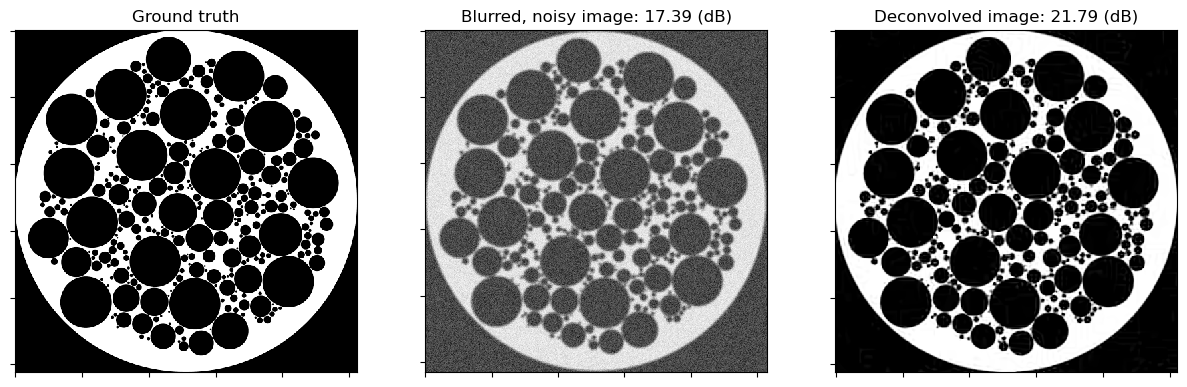

In [6]:
fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(15, 5))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0])
nc = n // 2
yc = snp.clip(y[nc:-nc, nc:-nc], 0, 1)
plot.imview(y, title="Blurred, noisy image: %.2f (dB)" % metric.psnr(x_gt, yc), fig=fig, ax=ax[1])
plot.imview(x, title="Deconvolved image: %.2f (dB)" % metric.psnr(x_gt, x), fig=fig, ax=ax[2])
fig.show()

Plot convergence statistics.

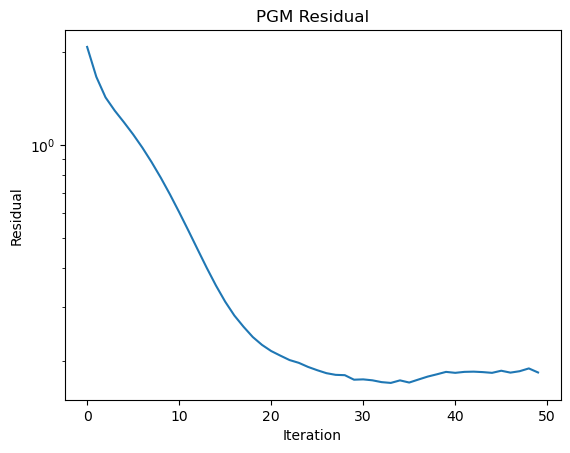

In [7]:
plot.plot(hist.Residual, ptyp="semilogy", title="PGM Residual", xlbl="Iteration", ylbl="Residual")